In [1]:
# Please run this line of code

#!pip install xgboost

# **'Health Insurance' project: Models** 

## [1- Considerations](#1)

## [2- Load basic modules and the csv files](#2)

## [3- Random Forest (RF)](#3)
- ### [A- Without tuning hyperparameters](#3.A)
- ### [A- RandomSearch CV](#3.B)

## [4- Logistic Regression (LR)](#4)
- ### [A- Without tuning hyperparameters](#4.A)
- ### [A- RandomSearch CV](#4.B)

## [5- XGBoost (XGB)](#5)
- ### [A- Without tuning hyperparameters](#5.A)
- ### [A- RandomSearch CV](#5.B)

## [6-AdaBoost (ADA)](#6)
- ### [A- Without tuning hyperparameters](#6.A)
- ### [A- RandomSearch CV](#6.B)

## [7- Client prediction](#7)

<a id='1'></a>

---

# 1- Considerations

**First consideration**

* Please remember that both this notebook and the notebook called `EDA.ipynb` are just the analysis and creation of models in an exploratory way, to finally be able to create the python scripts (`cleaning.py`, `model_search.py` and `clients_predict.py`). 

* It's a good idea to check the `Readme.md` so you can understand how the order of these scripts should be executed. 

* Our intention is to automate the final model chosen to be able to return a list of clients who have the possibility of contracting the insurance.

* You may find thie notebook a bit short, but again, our intention is to focus on the automation of a machine learning model.

**Second consideration**

* In addition to searching for the best value of `roc_auc`, we will also search for the best threshold. 

* For this we will consider a weight to the `false positives (FP)`. For `true positives (TP)` we will consider a gain of `$350` and for `FP` a loss of `$100`. 

* In this way we will seek the `threshold` that maximizes our profit.

<a id='2'></a>

---

# 2- Load basic modules and the csv files 

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# datetime library
import datetime

# Data preprocessing libraries
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import scipy.stats as st
from xgboost import plot_importance

# Metrics libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report


# Import functions from .py files
import sys
sys.path.append("../src/")
import metrics_description as md

pd.set_option('display.max_rows', 100)

In [3]:
train = pd.read_csv("../documents/train_model_notebook.csv")
val = pd.read_csv("../documents/val_model_notebook.csv")

In [4]:
train.rename(columns = {"Vehicle_Age_< 1 Year": "Vehicle_Age_lower 1 Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_higher 2 Years"}, inplace = True)
val.rename(columns = {"Vehicle_Age_< 1 Year": "Vehicle_Age_lower 1 Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_higher 2 Years"}, inplace = True)

In [5]:
print("Train model shape:", train.shape)
print("Validation model shape:", val.shape)

Train model shape: (252985, 14)
Validation model shape: (63247, 14)


In [6]:
train.head()

,Age,Vintage,Annual_Premium_log,Gender_Male,Driving_License_1,Previously_Insured_1,Vehicle_Age_lower 1 Year,Vehicle_Age_higher 2 Years,Vehicle_Damage_Yes,Policy_Sales_Channel_152.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_26.0,Policy_Sales_Channel_Other,Response
0,-0.600814,-0.170899,-1.065984,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,-0.088204,1.346765,-0.851296,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,-0.728967,-0.051398,-0.586140,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1
3,-0.985272,1.167513,-0.276639,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,1.129246,0.319056,-0.390680,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [7]:
val.head()

,Age,Vintage,Annual_Premium_log,Gender_Male,Driving_License_1,Previously_Insured_1,Vehicle_Age_lower 1 Year,Vehicle_Age_higher 2 Years,Vehicle_Damage_Yes,Policy_Sales_Channel_152.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_26.0,Policy_Sales_Channel_Other,Response
0,-0.793043,-0.601103,-0.470270,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,-0.600814,-0.959606,-1.179571,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,1.962238,0.940461,-1.274637,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0
3,-1.049348,-0.744504,-0.982115,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,-1.049348,-1.246408,-0.647128,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0


In [8]:
X_train_std = train.drop("Response", axis = 1)
y_train = train[["Response"]]
X_val_std = val.drop("Response", axis = 1)
y_val = val[["Response"]]

In [9]:
print("X_train_std shape:", X_train_std.shape)
print("y_train shape:", y_train.shape)
print("---" * 9)
print("X_val_std shape:", X_val_std.shape)
print("y_val shape:", y_val.shape)

X_train_std shape: (252985, 13)
y_train shape: (252985, 1)
---------------------------
X_val_std shape: (63247, 13)
y_val shape: (63247, 1)


In [10]:
model_results = pd.DataFrame({"Model": [], 
                              "Validation Recall": [], 
                              "Validation Precision": [],
                              "Val TP": [], "Val FP": [], "Val TN": [], "Val FN": [],
                              "Validation AUC": [], "Threshold": [], "Profit": [], "Execution Time": []})

In [11]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time


<a id='3'></a>

---

# 3- Random Forest (RF)

<a id='3.A'></a>

## A- Without tuning hyperparameters

In [12]:
rf = RandomForestClassifier(random_state = 123)

For RandomForestClassifier :
	Train Precision Score:1.000
	Validation Precision Score:0.347
	---	---	---	---
	Train Recall Score:1.000
	Validation Recall Score:0.156
	---	---	---	---
	Train ROC AUC Score:1.000
	Validation ROC AUC Score:0.832
------------------------------------------------------------------------------------------------------


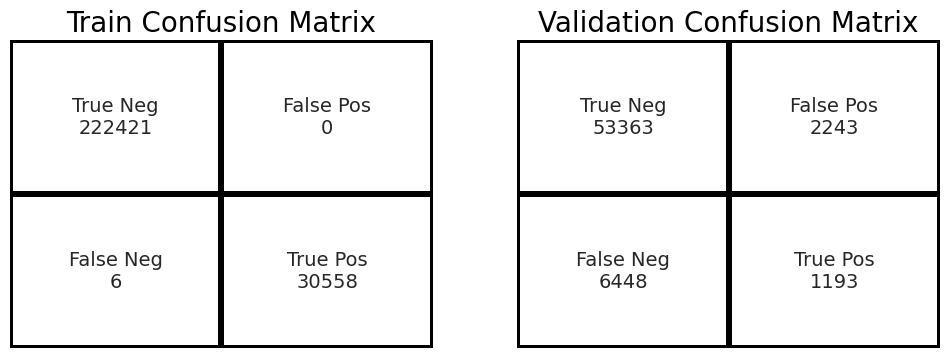

------------------------------------------------------------------------------------------------------


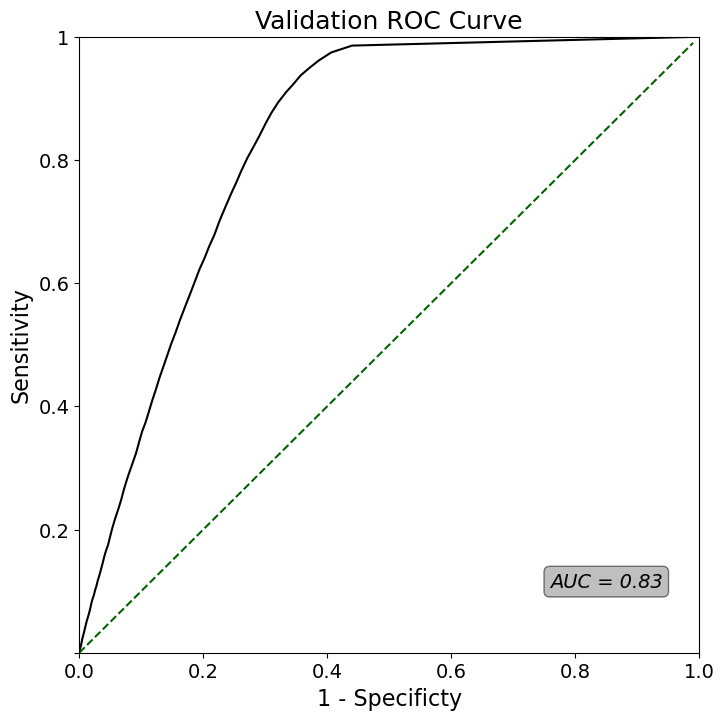

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     55606
           1       0.35      0.16      0.22      7641

    accuracy                           0.86     63247
   macro avg       0.62      0.56      0.57     63247
weighted avg       0.83      0.86      0.84     63247

Time it took to fit: 0.47 minutes.


In [13]:
start = datetime.datetime.now()

md.fit_train_val(rf, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

* Remember that in the case of having a `FP`, a penalty of -100 will be considered. 

* In case of having a `TP`, a gain of 350 will be considered.

In [14]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_rf = rf.predict_proba(X_val_std)[:, 1]
    y_pred_rf = [1 if y > i else 0 for y in y_pred_proba_rf]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_rf, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_rf = round(recall_score(y_val, y_pred_rf), 2)
    precision_rf = round(precision_score(y_val, y_pred_rf), 2)
    auc_rf = round(roc_auc_score(y_val, y_pred_proba_rf), 2)
    confusion_rf = confusion_matrix(y_val, y_pred_rf)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "RF clean", "Validation Recall": [recall_rf], "Validation Precision": [precision_rf], 
                                     "Val TP": [confusion_rf[1,1]], "Val FP": [confusion_rf[1,0]], "Val TN": [confusion_rf[0,0]], "Val FN": [confusion_rf[0,1]],
                                     "Validation AUC": [auc_rf], "Threshold": [i], "Profit": [pred_val["profit"].sum()], 
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [15]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47


* In this way, the `threshold` that maximizes the gain will be chosen, in this case it will have a `threshold = 0.3` for a `profit = 123,900`.

* The same process will be carried out for the following models and at the end the model with the highest gain will be chosen, together with its corresponding threshold.

<a id='3.B'></a>

## B- RandomSearch CV

The param_grid is created

In [16]:
param_grid = {"n_estimators": [100, 200],
              "class_weight": ["balanced"],
              "max_features": ["auto", "sqrt", "log2"],
              "max_depth" : [3, 5, 7, 8, 10],
              "min_samples_split": [0.005, 0.01, 0.05, 0.10, 0.25],
              "min_samples_leaf": [0.005, 0.01, 0.05, 0.10, 0.25],
              "criterion" :["gini", "entropy"]}

In [17]:
rf_rscv = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 3, n_iter = 20, scoring = "roc_auc", n_jobs = -1, verbose = 1)

In [18]:
start = datetime.datetime.now()

rf_rscv.fit(X_train_std, y_train.values.reshape(-1))

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Time it took to fit: 1.7 minutes.


In [19]:
print("Best params:", rf_rscv.best_params_)
print("Best score:", rf_rscv.best_score_.round(2))

Best params: {'n_estimators': 100, 'min_samples_split': 0.01, 'min_samples_leaf': 0.005, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score: 0.86


In [20]:
rf_rscv_model = rf_rscv.best_estimator_
rf_rscv_model

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=0.005,
                       min_samples_split=0.01, random_state=123)

In [21]:
# Borrar esta linea al terminar todo

rf_rscv_model = RandomForestClassifier(n_estimators = 200,
                                       min_samples_split = 0.05,
                                       min_samples_leaf = 0.005,
                                       max_features = "auto",
                                       max_depth = 5,
                                       criterion = "gini",
                                       class_weight = "balanced")

For RandomForestClassifier :
	Train Precision Score:0.288
	Validation Precision Score:0.286
	---	---	---	---
	Train Recall Score:0.917
	Validation Recall Score:0.911
	---	---	---	---
	Train ROC AUC Score:0.853
	Validation ROC AUC Score:0.852
------------------------------------------------------------------------------------------------------


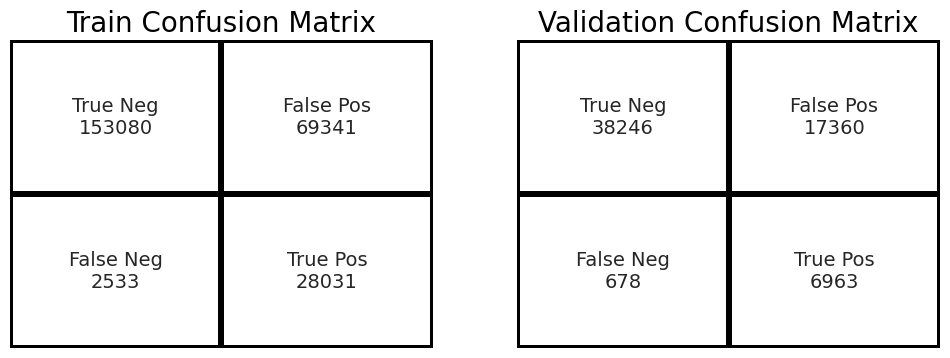

------------------------------------------------------------------------------------------------------


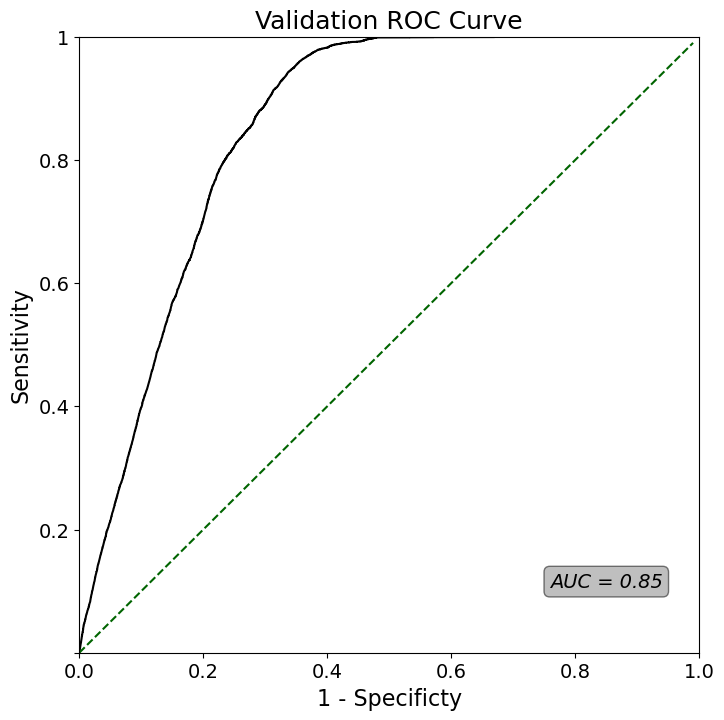

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     55606
           1       0.29      0.91      0.44      7641

    accuracy                           0.71     63247
   macro avg       0.63      0.80      0.62     63247
weighted avg       0.90      0.71      0.76     63247

Time it took to fit: 0.28 minutes.


In [22]:
start = datetime.datetime.now()

md.fit_train_val(rf_rscv_model, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

In [23]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_rf_rscv = rf_rscv_model.predict_proba(X_val_std)[:, 1]
    y_pred_rf_rscv = [1 if y > i else 0 for y in y_pred_proba_rf_rscv]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_rf_rscv, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_rf_rscv = round(recall_score(y_val, y_pred_rf_rscv), 2)
    precision_rf_rscv = round(precision_score(y_val, y_pred_rf_rscv), 2)
    auc_rf_rscv = round(roc_auc_score(y_val, y_pred_proba_rf_rscv), 2)
    confusion_rf_rscv = confusion_matrix(y_val, y_pred_rf_rscv)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "RF + RSCV", "Validation Recall": [recall_rf_rscv], "Validation Precision": [precision_rf_rscv], 
                                     "Val TP": [confusion_rf_rscv[1,1]], "Val FP": [confusion_rf_rscv[1,0]], "Val TN": [confusion_rf_rscv[0,0]], "Val FN": [confusion_rf_rscv[0,1]],
                                     "Validation AUC": [auc_rf_rscv], "Threshold": [i], "Profit": [pred_val["profit"].sum()],
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [24]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


<a id='4'></a>

---

# 4- Logistic Regression (LR)

<a id='4.A'></a>

## A- Without tuning hyperparameters

In [25]:
lr = LogisticRegression(random_state = 123)

For LogisticRegression :
	Train Precision Score:0.068
	Validation Precision Score:0.231
	---	---	---	---
	Train Recall Score:0.000
	Validation Recall Score:0.000
	---	---	---	---
	Train ROC AUC Score:0.853
	Validation ROC AUC Score:0.853
------------------------------------------------------------------------------------------------------


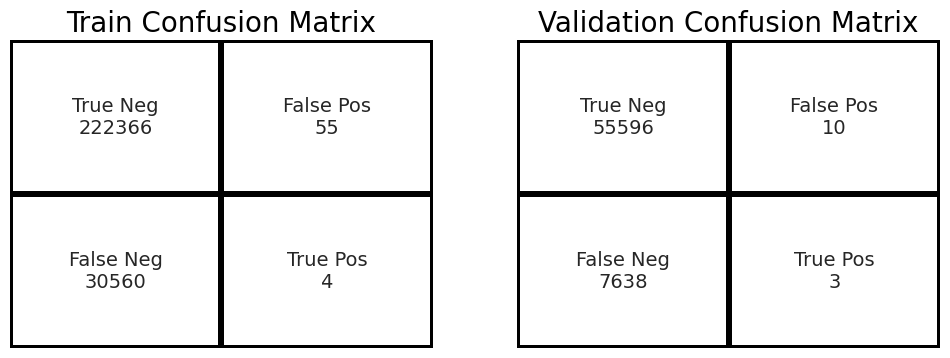

------------------------------------------------------------------------------------------------------


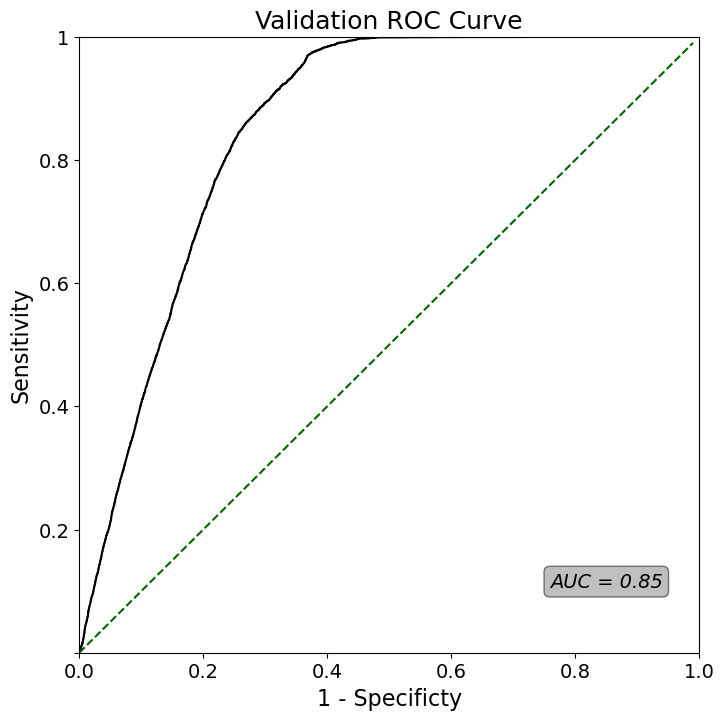

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     55606
           1       0.23      0.00      0.00      7641

    accuracy                           0.88     63247
   macro avg       0.55      0.50      0.47     63247
weighted avg       0.80      0.88      0.82     63247

Time it took to fit: 0.02 minutes.


In [26]:
start = datetime.datetime.now()

md.fit_train_val(lr, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

* Remember that in the case of having a `FP`, a penalty of -100 will be considered. 

* In case of having a `TP`, a gain of 350 will be considered.

In [27]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_lr = lr.predict_proba(X_val_std)[:, 1]
    y_pred_lr = [1 if y > i else 0 for y in y_pred_proba_lr]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_lr, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_lr = round(recall_score(y_val, y_pred_lr), 2)
    precision_lr = round(precision_score(y_val, y_pred_lr), 2)
    auc_lr = round(roc_auc_score(y_val, y_pred_proba_lr), 2)
    confusion_lr = confusion_matrix(y_val, y_pred_lr)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "LR clean", "Validation Recall": [recall_lr], "Validation Precision": [precision_lr], 
                                     "Val TP": [confusion_lr[1,1]], "Val FP": [confusion_lr[1,0]], "Val TN": [confusion_lr[0,0]], "Val FN": [confusion_lr[0,1]],
                                     "Validation AUC": [auc_lr], "Threshold": [i], "Profit": [pred_val["profit"].sum()],
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [28]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


<a id='4.B'></a>

## B- RandomSearch CV

The param_grid is created

In [29]:
param_grid = {"penalty" : ["l1", "l2"], 
              "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "solver": ["liblinear"],
              "class_weight": ["balanced", {0: 0.10, 1: 0.90}, 
                                           {0: 0.20, 1: 0.80},
                                           {0: 0.30, 1: 0.70},
                                           {0: 0.40, 1: 0.60},
                                           {0: 0.50, 1: 0.50},
                                           {0: 0.60, 1: 0.40},
                                           {0: 0.70, 1: 0.30},
                                           {0: 0.80, 1: 0.20},
                                           {0: 0.90, 1: 0.10}]}

In [30]:
lr_rscv = RandomizedSearchCV(estimator = lr, param_distributions = param_grid, cv = 3, n_iter = 40, scoring = "roc_auc", n_jobs = -1, verbose = 1)

In [31]:
lr_rscv = RandomizedSearchCV(estimator = lr, param_distributions = param_grid, cv = 3, n_iter = 1, scoring = "roc_auc", n_jobs = -1, verbose = 0)

In [32]:
lr_rscv.fit(X_train_std, y_train.values.reshape(-1))

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=123),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'class_weight': ['balanced',
                                                         {0: 0.1, 1: 0.9},
                                                         {0: 0.2, 1: 0.8},
                                                         {0: 0.3, 1: 0.7},
                                                         {0: 0.4, 1: 0.6},
                                                         {0: 0.5, 1: 0.5},
                                                         {0: 0.6, 1: 0.4},
                                                         {0: 0.7, 1: 0.3},
                                                         {0: 0.8, 1: 0.2},
                                                         {0: 0.9, 1: 0.1}],
             

In [36]:
start = datetime.datetime.now()

lr_rscv.fit(X_train_std, y_train.values.reshape(-1))

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

Time it took to fit: 0.02 minutes.


In [37]:
print("Best params:", lr_rscv.best_params_)
print("Best score:", lr_rscv.best_score_.round(2))

Best params: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}
Best score: 0.85


In [38]:
lr_rscv_model = lr_rscv.best_estimator_
lr_rscv_model

LogisticRegression(C=0.01, class_weight='balanced', random_state=123,
                   solver='liblinear')

In [39]:
# Borrar esta linea al terminar todo

lr_rscv_model = LogisticRegression(C=1000, class_weight={0: 0.9, 1: 0.1}, random_state=123, solver='liblinear')

For LogisticRegression :
	Train Precision Score:0.000
	Validation Precision Score:0.000
	---	---	---	---
	Train Recall Score:0.000
	Validation Recall Score:0.000
	---	---	---	---
	Train ROC AUC Score:0.853
	Validation ROC AUC Score:0.853
------------------------------------------------------------------------------------------------------


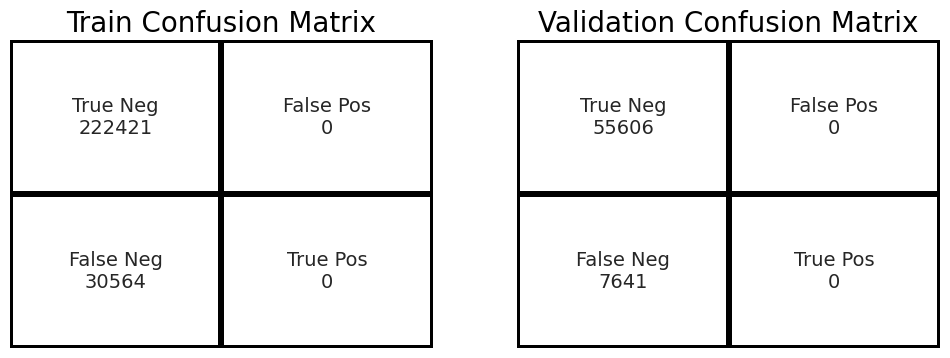

------------------------------------------------------------------------------------------------------


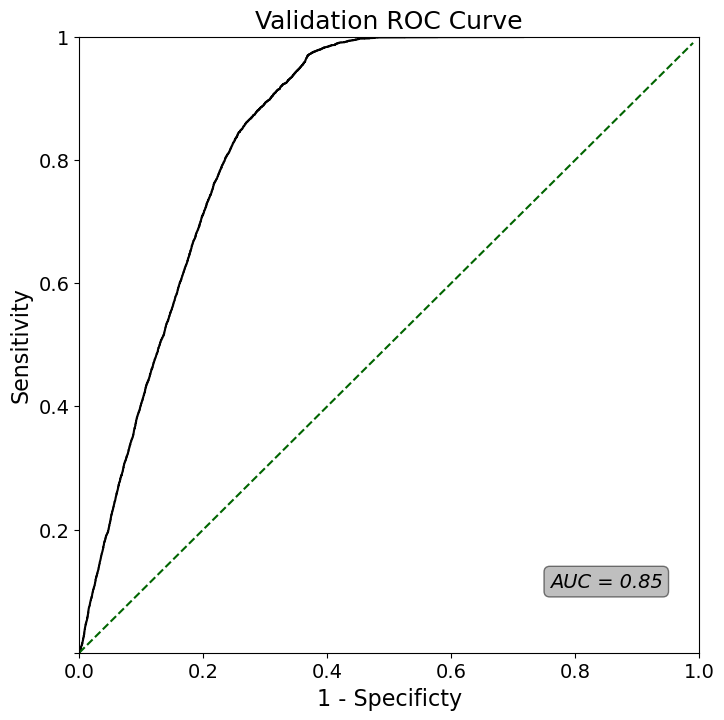

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     55606
           1       0.00      0.00      0.00      7641

    accuracy                           0.88     63247
   macro avg       0.44      0.50      0.47     63247
weighted avg       0.77      0.88      0.82     63247

Time it took to fit: 0.02 minutes.


In [40]:
start = datetime.datetime.now()

md.fit_train_val(lr_rscv_model, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

In [41]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_lr_rscv = lr_rscv_model.predict_proba(X_val_std)[:, 1]
    y_pred_lr_rscv = [1 if y > i else 0 for y in y_pred_proba_lr_rscv]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_lr_rscv, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_lr_rscv = round(recall_score(y_val, y_pred_lr_rscv), 2)
    precision_lr_rscv = round(precision_score(y_val, y_pred_lr_rscv), 2)
    auc_lr_rscv = round(roc_auc_score(y_val, y_pred_proba_lr_rscv), 2)
    confusion_lr_rscv = confusion_matrix(y_val, y_pred_lr_rscv)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "LR + RSCV", "Validation Recall": [recall_lr_rscv], "Validation Precision": [precision_lr_rscv], 
                                     "Val TP": [confusion_lr_rscv[1,1]], "Val FP": [confusion_lr_rscv[1,0]], "Val TN": [confusion_lr_rscv[0,0]], "Val FN": [confusion_lr_rscv[0,1]],
                                     "Validation AUC": [auc_lr_rscv], "Threshold": [i], "Profit": [pred_val["profit"].sum()],
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [42]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


<a id='5'></a>

---

# 5- XGBoost (XGB)

<a id='5.A'></a>

## A- Without tuning hyperparameters

In [43]:
xgb = XGBClassifier(random_state = 123)

For XGBClassifier :
	Train Precision Score:0.786
	Validation Precision Score:0.471
	---	---	---	---
	Train Recall Score:0.038
	Validation Recall Score:0.019
	---	---	---	---
	Train ROC AUC Score:0.881
	Validation ROC AUC Score:0.860
------------------------------------------------------------------------------------------------------


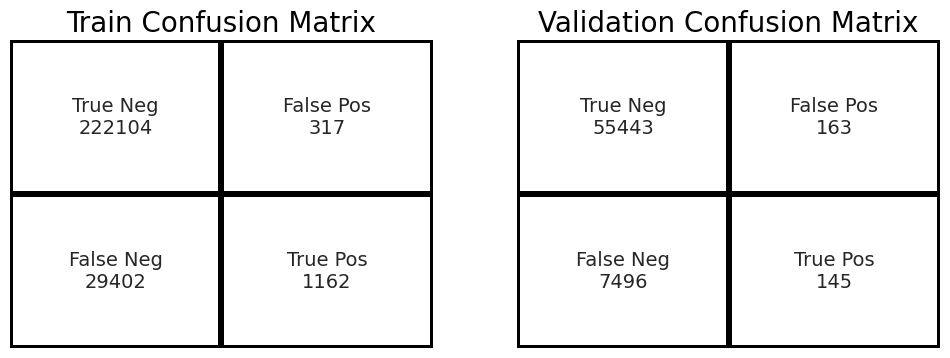

------------------------------------------------------------------------------------------------------


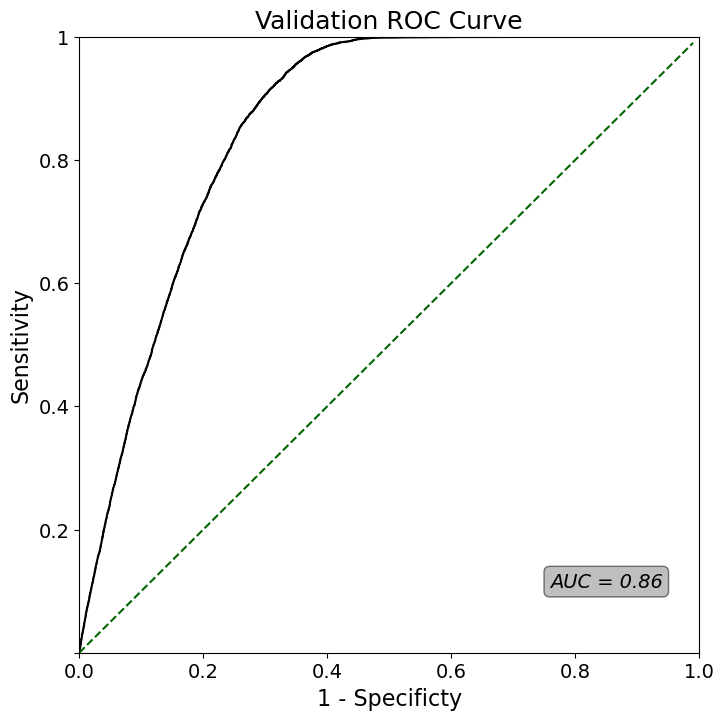

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     55606
           1       0.47      0.02      0.04      7641

    accuracy                           0.88     63247
   macro avg       0.68      0.51      0.49     63247
weighted avg       0.83      0.88      0.83     63247

Time it took to fit: 0.1 minutes.


In [44]:
start = datetime.datetime.now()

md.fit_train_val(xgb, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

* Remember that in the case of having a `FP`, a penalty of -100 will be considered. 

* In case of having a `TP`, a gain of 350 will be considered.

In [45]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_xgb = xgb.predict_proba(X_val_std)[:, 1]
    y_pred_xgb = [1 if y > i else 0 for y in y_pred_proba_xgb]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_xgb, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_xgb = round(recall_score(y_val, y_pred_xgb), 2)
    precision_xgb = round(precision_score(y_val, y_pred_xgb), 2)
    auc_xgb = round(roc_auc_score(y_val, y_pred_proba_xgb), 2)
    confusion_xgb = confusion_matrix(y_val, y_pred_xgb)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "XGB clean", "Validation Recall": [recall_xgb], "Validation Precision": [precision_xgb], 
                                     "Val TP": [confusion_xgb[1,1]], "Val FP": [confusion_xgb[1,0]], "Val TN": [confusion_xgb[0,0]], "Val FN": [confusion_xgb[0,1]],
                                     "Validation AUC": [auc_xgb], "Threshold": [i], "Profit": [pred_val["profit"].sum()],
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [46]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


<a id='5.B'></a>

## B- RandomSearch CV

The param_grid is created

In [47]:
param_grid = {"n_estimators": st.randint(20,40), 
              "max_depth": st.randint(3, 12), 
              "learning_rate": st.uniform(0.05, 0.4),
              "colsample_bytree": st.beta(10, 1), 
              "subsample": st.beta(10, 1), 
              "gamma": st.uniform(0, 10),
              "reg_alpha": st.uniform(0.05,10), 
              "min_child_weight": st.uniform(1,20)}

In [48]:
xgb_rscv = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid, cv = 3, n_iter = 20, scoring = "roc_auc", n_jobs = -1, verbose = 1)

In [49]:
start = datetime.datetime.now()

xgb_rscv.fit(X_train_std, y_train.values.reshape(-1))

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Time it took to fit: 0.85 minutes.


In [50]:
# Fitting 3 folds for each of 10 candidates, totalling 30 fits
# Time it took to fit: 12.03 minutes.

print("Best params:", xgb_rscv.best_params_)
print("Best score:", xgb_rscv.best_score_.round(2))

Best params: {'colsample_bytree': 0.8724688094221484, 'gamma': 2.939040675288979, 'learning_rate': 0.18363893335479803, 'max_depth': 8, 'min_child_weight': 3.8101159015152133, 'n_estimators': 21, 'reg_alpha': 5.183763909167177, 'subsample': 0.9681772275910324}
Best score: 0.86


In [51]:
xgb_rscv_model = xgb_rscv.best_estimator_
xgb_rscv_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8724688094221484, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.939040675288979, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.18363893335479803, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=3.8101159015152133,
              missing=nan, monotone_constraints='()', n_estimators=21, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=123, ...)

In [52]:
# Borrar esta linea al terminar todo

#xgb_rscv_model = LogisticRegression(C=1000, class_weight={0: 0.9, 1: 0.1}, random_state=123, solver='liblinear')

For XGBClassifier :
	Train Precision Score:0.696
	Validation Precision Score:0.676
	---	---	---	---
	Train Recall Score:0.003
	Validation Recall Score:0.003
	---	---	---	---
	Train ROC AUC Score:0.864
	Validation ROC AUC Score:0.862
------------------------------------------------------------------------------------------------------


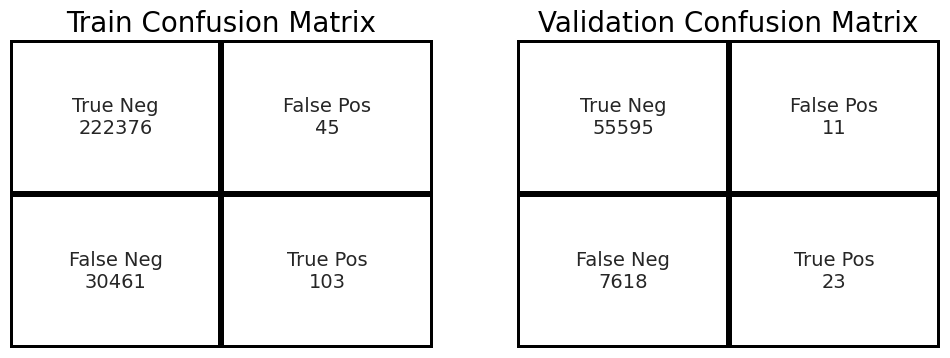

------------------------------------------------------------------------------------------------------


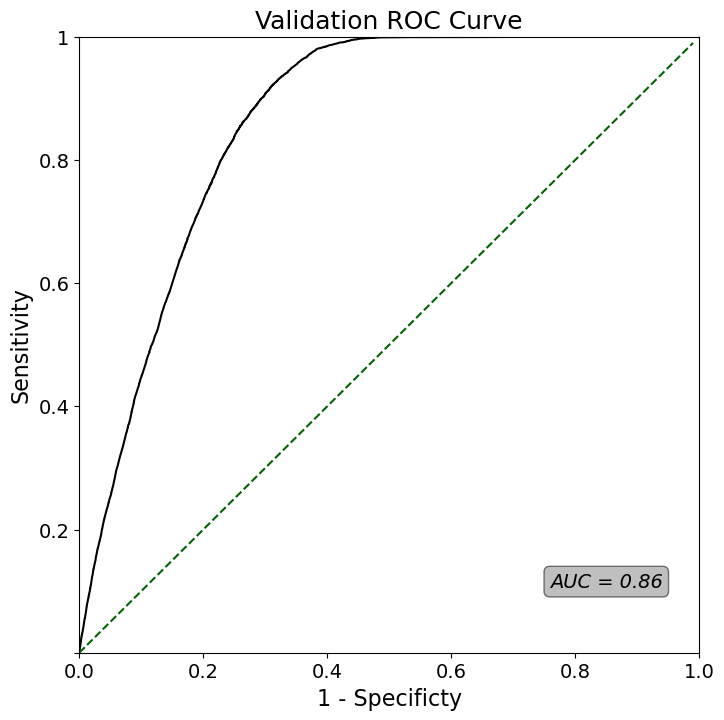

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     55606
           1       0.68      0.00      0.01      7641

    accuracy                           0.88     63247
   macro avg       0.78      0.50      0.47     63247
weighted avg       0.85      0.88      0.82     63247

Time it took to fit: 0.03 minutes.


In [53]:
start = datetime.datetime.now()

md.fit_train_val(xgb_rscv_model, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

In [54]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_xgb_rscv = xgb_rscv_model.predict_proba(X_val_std)[:, 1]
    y_pred_xgb_rscv = [1 if y > i else 0 for y in y_pred_proba_xgb_rscv]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_xgb_rscv, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_xgb_rscv = round(recall_score(y_val, y_pred_xgb_rscv), 2)
    precision_xgb_rscv = round(precision_score(y_val, y_pred_xgb_rscv), 2)
    auc_xgb_rscv = round(roc_auc_score(y_val, y_pred_proba_xgb_rscv), 2)
    confusion_xgb_rscv = confusion_matrix(y_val, y_pred_xgb_rscv)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "XGB + RSCV", "Validation Recall": [recall_xgb_rscv], "Validation Precision": [precision_xgb_rscv], 
                                     "Val TP": [confusion_xgb_rscv[1,1]], "Val FP": [confusion_xgb_rscv[1,0]], "Val TN": [confusion_xgb_rscv[0,0]], "Val FN": [confusion_xgb_rscv[0,1]],
                                     "Validation AUC": [auc_xgb_rscv], "Threshold": [i], "Profit": [pred_val["profit"].sum()],
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [55]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


<a id='6'></a>

---

# 6- AdaBoost (ADA)

<a id='6.A'></a>

## A- Without tuning hyperparameters

In [56]:
ada = AdaBoostClassifier(random_state = 123)

For AdaBoostClassifier :
	Train Precision Score:0.333
	Validation Precision Score:0.000
	---	---	---	---
	Train Recall Score:0.001
	Validation Recall Score:0.000
	---	---	---	---
	Train ROC AUC Score:0.860
	Validation ROC AUC Score:0.860
------------------------------------------------------------------------------------------------------


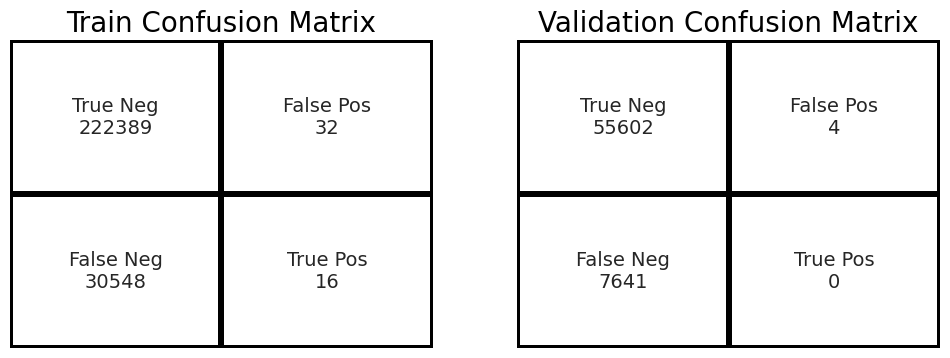

------------------------------------------------------------------------------------------------------


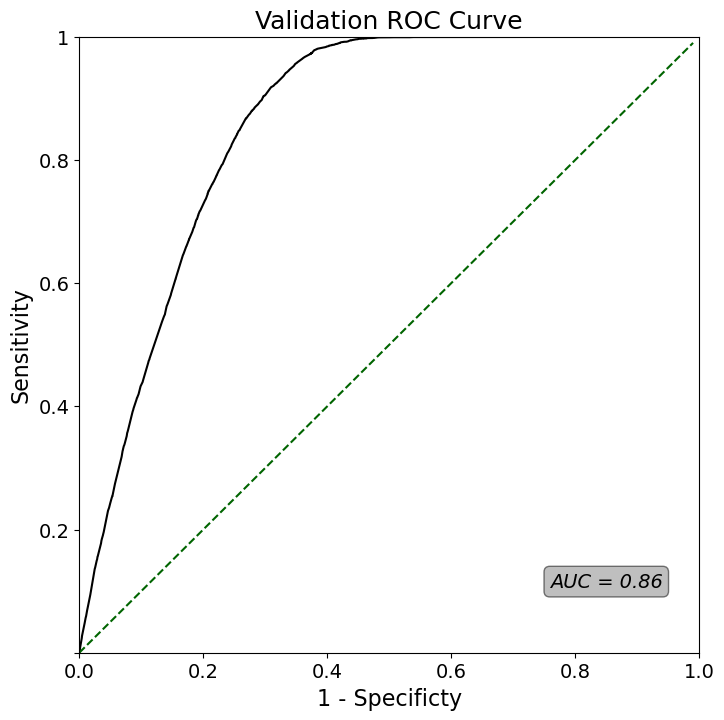

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     55606
           1       0.00      0.00      0.00      7641

    accuracy                           0.88     63247
   macro avg       0.44      0.50      0.47     63247
weighted avg       0.77      0.88      0.82     63247

Time it took to fit: 0.1 minutes.


In [57]:
start = datetime.datetime.now()

md.fit_train_val(ada, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

In [58]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_ada = ada.predict_proba(X_val_std)[:, 1]
    y_pred_ada = [1 if y > i else 0 for y in y_pred_proba_ada]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_ada, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_ada = round(recall_score(y_val, y_pred_ada), 2)
    precision_ada = round(precision_score(y_val, y_pred_ada), 2)
    auc_ada = round(roc_auc_score(y_val, y_pred_proba_ada), 2)
    confusion_ada = confusion_matrix(y_val, y_pred_ada)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "ADA clean", "Validation Recall": [recall_ada], "Validation Precision": [precision_ada], 
                                     "Val TP": [confusion_ada[1,1]], "Val FP": [confusion_ada[1,0]], "Val TN": [confusion_ada[0,0]], "Val FN": [confusion_ada[0,1]],
                                     "Validation AUC": [auc_ada], "Threshold": [i], "Profit": [pred_val["profit"].sum()],
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [59]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


<a id='6.B'></a>

## B- RandomSearch CV

The param_grid is created

In [60]:
param_grid = {"n_estimators": [10, 50, 100, 200, 500],
              "learning_rate": [0.0001, 0.01, 0.1, 1.0, 1.1, 1.2]}

In [61]:
ada_rscv = RandomizedSearchCV(estimator = ada, param_distributions = param_grid, cv = 3, n_iter = 20, scoring = "roc_auc", n_jobs = -1, verbose = 1)

In [62]:
start = datetime.datetime.now()

ada_rscv.fit(X_train_std, y_train.values.reshape(-1))

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Time it took to fit: 5.88 minutes.


In [63]:
# Fitting 3 folds for each of 10 candidates, totalling 30 fits
# Time it took to fit: 12.03 minutes.

print("Best params:", ada_rscv.best_params_)
print("Best score:", ada_rscv.best_score_.round(2))

Best params: {'n_estimators': 500, 'learning_rate': 0.1}
Best score: 0.86


In [64]:
ada_rscv_model = ada_rscv.best_estimator_
ada_rscv_model

AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=123)

For AdaBoostClassifier :
	Train Precision Score:0.318
	Validation Precision Score:0.000
	---	---	---	---
	Train Recall Score:0.000
	Validation Recall Score:0.000
	---	---	---	---
	Train ROC AUC Score:0.860
	Validation ROC AUC Score:0.860
------------------------------------------------------------------------------------------------------


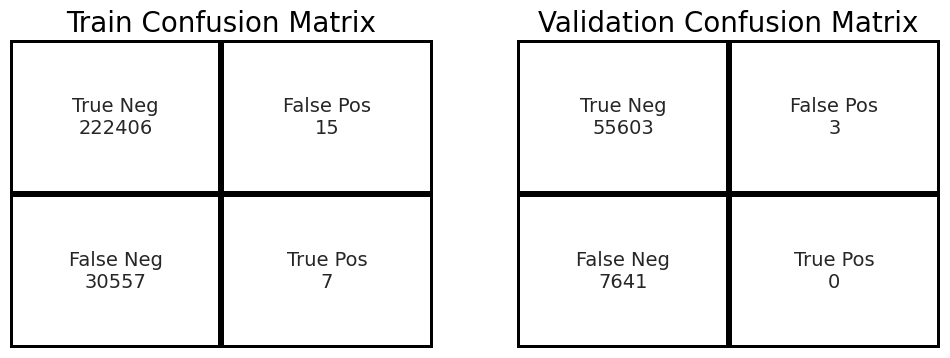

------------------------------------------------------------------------------------------------------


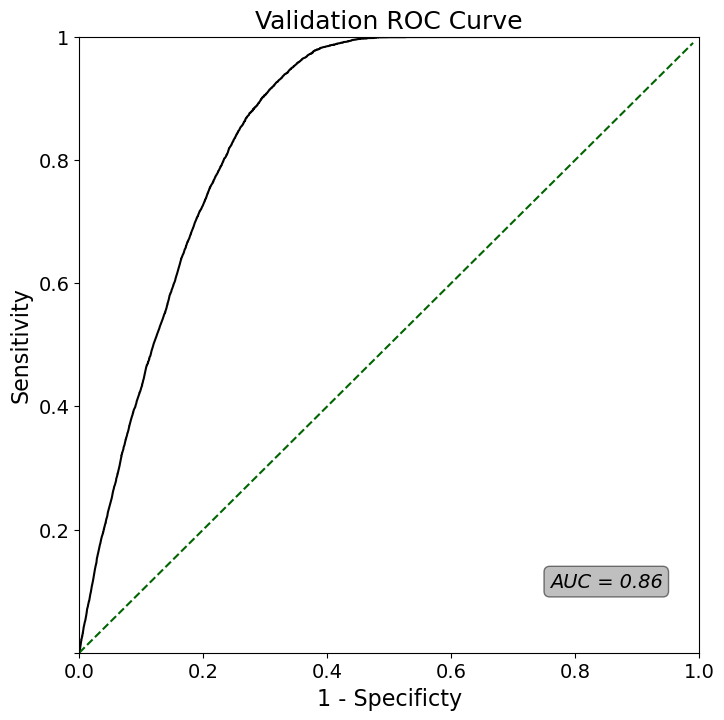

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     55606
           1       0.00      0.00      0.00      7641

    accuracy                           0.88     63247
   macro avg       0.44      0.50      0.47     63247
weighted avg       0.77      0.88      0.82     63247

Time it took to fit: 1.65 minutes.


In [65]:
start = datetime.datetime.now()

md.fit_train_val(ada_rscv_model, X_train_std, y_train, X_val_std, y_val)

end = datetime.datetime.now()
delta = round((end - start).seconds / 60, 2)
print(f"Time it took to fit: {delta} minutes.")

**Append results**

In [66]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold:
    # generating predictions
    y_pred_proba_ada_rscv = xgb_rscv_model.predict_proba(X_val_std)[:, 1]
    y_pred_ada_rscv = [1 if y > i else 0 for y in y_pred_proba_ada_rscv]
    
    # FP = -100 and TP = 350
    pred_val = pd.DataFrame({"y_pred": y_pred_ada_rscv, "y_val": y_val.values.reshape(-1)})
    pred_val["profit"] = (pred_val["y_pred"] * (-100)) + (pred_val["y_pred"] * pred_val["y_val"] * 350)

    # calculating metrics
    recall_ada_rscv = round(recall_score(y_val, y_pred_ada_rscv), 2)
    precision_ada_rscv = round(precision_score(y_val, y_pred_ada_rscv), 2)
    auc_ada_rscv = round(roc_auc_score(y_val, y_pred_proba_ada_rscv), 2)
    confusion_ada_rscv = confusion_matrix(y_val, y_pred_ada_rscv)

    # generating a concatenating results
    results = pd.DataFrame({"Model": "ADA + RSCV", "Validation Recall": [recall_ada_rscv], "Validation Precision": [precision_ada_rscv], 
                                     "Val TP": [confusion_ada_rscv[1,1]], "Val FP": [confusion_ada_rscv[1,0]], "Val TN": [confusion_ada_rscv[0,0]], "Val FN": [confusion_ada_rscv[0,1]],
                                     "Validation AUC": [auc_ada_rscv], "Threshold": [i], "Profit": [pred_val["profit"].sum()],
                                     "Execution Time": delta})
    model_results = pd.concat([model_results, results], axis = 0, ignore_index = True)

In [67]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


In [68]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


In [69]:
model_results.loc[26, "Profit"] = 299000.0

In [70]:
model_results

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
0,RF clean,0.84,0.28,6406.0,1235.0,39473.0,16133.0,0.83,0.1,-11800.0,0.47
1,RF clean,0.64,0.30,4888.0,2753.0,44393.0,11213.0,0.83,0.2,100700.0,0.47
2,RF clean,0.45,0.32,3406.0,4235.0,48422.0,7184.0,0.83,0.3,133100.0,0.47
3,RF clean,0.28,0.33,2141.0,5500.0,51350.0,4256.0,0.83,0.4,109650.0,0.47
4,RF clean,0.16,0.35,1193.0,6448.0,53363.0,2243.0,0.83,0.5,73950.0,0.47
5,RF clean,0.07,0.36,573.0,7068.0,54585.0,1021.0,0.83,0.6,41150.0,0.47
6,RF clean,0.03,0.38,205.0,7436.0,55268.0,338.0,0.83,0.7,17450.0,0.47
7,RF clean,0.01,0.42,48.0,7593.0,55541.0,65.0,0.83,0.8,5500.0,0.47
8,RF clean,0.00,0.12,1.0,7640.0,55599.0,7.0,0.83,0.9,-450.0,0.47
9,RF + RSCV,1.00,0.22,7632.0,9.0,28147.0,27459.0,0.85,0.1,-837900.0,0.28


In [71]:
best_models = model_results[model_results["Profit"] == model_results["Profit"].max()]
best_models

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
47,XGB + RSCV,0.62,0.35,4770.0,2871.0,46837.0,8769.0,0.86,0.3,315600.0,0.03
65,ADA + RSCV,0.62,0.35,4770.0,2871.0,46837.0,8769.0,0.86,0.3,315600.0,1.65


In [72]:
best_models.loc[best_models["Execution Time"].idxmin(), "Model"]

'XGB + RSCV'

In [73]:
best_models.loc[best_models["Execution Time"].idxmin(), "Threshold"]

0.3

In [74]:
model_results.loc[model_results["Profit"].idxmax(), "Model"]

'XGB + RSCV'

In [75]:
model_results.loc[model_results["Profit"].idxmax(), "Threshold"]

0.3

In [76]:
best_model = model_results[model_results["Profit"] == model_results["Profit"].max()]
best_model

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
47,XGB + RSCV,0.62,0.35,4770.0,2871.0,46837.0,8769.0,0.86,0.3,315600.0,0.03
65,ADA + RSCV,0.62,0.35,4770.0,2871.0,46837.0,8769.0,0.86,0.3,315600.0,1.65


In [77]:
final_model = best_model[best_model["Execution Time"] == best_model["Execution Time"].min()]
final_model

,Model,Validation Recall,Validation Precision,Val TP,Val FP,Val TN,Val FN,Validation AUC,Threshold,Profit,Execution Time
47,XGB + RSCV,0.62,0.35,4770.0,2871.0,46837.0,8769.0,0.86,0.3,315600.0,0.03


<a id='7'></a>

---

# 7- Client prediction

In [78]:
test_model = pd.read_csv("../documents/test_model_notebook.csv", index_col = "id")

In [79]:
test_model.rename(columns = {"Vehicle_Age_< 1 Year": "Vehicle_Age_lower 1 Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_higher 2 Years"}, inplace = True)

In [80]:
print("Shape:", test_model.shape)
test_model.head()

Shape: (105426, 13)


,Age,Vintage,Annual_Premium_log,Gender_Male,Driving_License_1,Previously_Insured_1,Vehicle_Age_lower 1 Year,Vehicle_Age_higher 2 Years,Vehicle_Damage_Yes,Policy_Sales_Channel_152.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_26.0,Policy_Sales_Channel_Other
id,,,,,,,,,,,,,
381110,-0.857119,-1.210558,0.106519,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
381111,0.104025,-0.517452,-0.092865,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
381112,0.552559,0.534157,0.492036,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
381113,-0.921196,0.390756,0.253562,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
381114,-0.728967,1.705268,1.824390,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [81]:
submissions_pred_proba = xgb_rscv_model.predict_proba(test_model)[:, 1]
submissions_pred = [1 if y > 0.3 else 0 for y in submissions_pred_proba]

In [82]:
test_model["Prediction"] = submissions_pred
test_model["Probability"] = submissions_pred_proba

In [83]:
test_model[["Prediction", "Probability"]].head()

,Prediction,Probability
id,,
381110,0,0.011695
381111,1,0.321889
381112,1,0.301860
381113,0,0.020338
381114,0,0.011695


In [87]:
test_model[test_model["Prediction"] == 1].shape

(22529, 15)

In [88]:
id_clients = test_model[test_model["Prediction"] == 1].index.tolist()
id_clients[:5]

[381111, 381112, 381123, 381127, 381150]

* Conclusion: 
    - Our predictive model will use either a `XGB + RSCV` or `ADA + RSCV` model. 
    - The `threshold` will be 0.3 for both cases 
    - Since the maximum `profit` was `315700.00`

* Final considerations:
    - Once again, this notebook does not have the objective of automating the modeling, but of being able to visualize the performance of each model, to have a notion when automating.
    - The automation process will be done with the python scripts.